# Lumen Data Science

U sljedećoj liniji instaliramo potrebne biblioteke.

Ako ne vrtimo na lokalnom okruženju (kojeg dobivamo prateći upute s githuba),
potrebno je zamijeniti False sa True.

To će privremeno instalirati sve potrebne biblioteke.

In [41]:
if False:
    !pip install -Uqq fastai
    !pip install -Uqq librosa
    !pip install -Uqq matplotlib

In [43]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
import re
import itertools

In [3]:
import matplotlib.pyplot as plot
from IPython.display import Audio
from IPython.utils import io
sys.path.append('../')

## Label getters

Naveli smo u projektnoj dokumentaciji da je IRMAS_dataset potrebno dodatno podijeliti. Dio Validation foldera treba prebaciti u novokreirani test folder (oko 20%). Inače program neće raditi!

Alternativa je sve raditi na valdiation dati, a za to je potrebno malo mijenjati notebook.

In [4]:
train_path = Path("./Dataset/Dataset/IRMAS_Training_Data")
noise_path = Path("./Dataset/Dataset/IRMAS_Training_Data/noi")
valid_path = Path("./Dataset/Dataset/IRMAS_Validation_Data")
test_path = Path("./Dataset/Dataset/IRMAS_Test_Data")
grand_path = Path("./Dataset/Dataset")

In [5]:
get_song_files = FileGetter(extensions='.wav', recurse=True)

In [6]:
def is_IRMAS_train(pat: Path):
    return str(pat).find("IRMAS_Training_Data") != -1

def is_IRMAS_valid(pat: Path):
    return str(pat).find("IRMAS_Validation_Data") != -1
    
def is_IRMAS_test(pat: Path):
    return str(pat).find("IRMAS_Test_Data") != -1

In [7]:
song_path = Path("./Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
is_IRMAS_train(song_path), is_IRMAS_valid(song_path)

(False, True)

IRMAS train i valid drugačije su anotirani. Train sadrži instrument u svom nazivu (u prvoj zagradi) te je grupiran u foldere po instrumentima. Koristimo regex da bi pronašli naziv.

Validation data sve instrumente ima u tekstualnoj datoteci.

In [8]:
def get_IRMAS_train_label(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []

In [9]:
song_path = Path("./Dataset/Dataset/IRMAS_Training_Data/cel/132__[cel][nod][cla]0048__3")
get_IRMAS_train_label(song_path)

['cel']

In [10]:
def get_IRMAS_valid_label(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()

In [11]:
song_path = Path("./Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav")
get_IRMAS_valid_label(song_path)

['gel']

Sljedeću klasu koristimo kako bi u model mogli osim puta do datoteke ubaciti i trenutak u kojemu želimo uzeti klip ako pjesma traje dulje od 3 sekunde. Ovo će olakšati kasniju izradu pomičnih prozora za validaciju.

In [12]:
class PathPt():
    def __init__(self, pat, i):
        self.pat=pat
        self.i = i

In [13]:
class PathNp():
    def __init__(self, y, i):
        self.y = y
        self.i = i

In [14]:
def get_label(pat):
    if isinstance(pat, PathPt): pat=pat.pat
    if not isinstance(pat, Path): raise TypeError(f"{type(song)} is invalid type to get song!")
    if is_IRMAS_train(pat):
        return get_IRMAS_train_label(pat)
    return get_IRMAS_valid_label(pat)

def get_single_label(pat: Path):
    return get_label(pat)[0]

In [15]:
song_path = Path("./Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav")
get_label(song_path)

['gel']

## Analiza dataseta

Računamo uspješnost različitih pretpostavljenih modela koje smo naveli u projektnoj dokumentaciji, primjerice model koji uvijek vraća da ne svira nijedan instrument.

In [16]:
train_items = get_song_files(train_path)
valid_items = get_song_files(valid_path)
test_items = get_song_files(test_path)
items = train_items + valid_items + test_items;

In [17]:
cla_items = get_song_files(grand_path/"IRMAS_Training_Data"/"cla")

In [18]:
avg = np.average([len(get_label(f)) for f in test_items])
print("Average insruments: ", avg)

# Average accuracy when model outputs only zeros
all_z_ac = 1 - avg/11
print("All zeros model:", all_z_ac)

# If model can classify one instrument with accuracy
# of ac, then total accuracy will be less than:
ac = 0.85
one_l_ac = ac * (1 - (avg - 1)/11) + (1-ac) * (1 - (avg + 1)/11)
print(f"One label model ({ac}):", one_l_ac)


# if model can classify 1.7 instruments with accuracy
# of ac, and miss them otherwise:
ac = 0.85
all_l_ac = ac + (1-ac) * (1 - (avg *2)/11)
print(f"All model: ({ac})", all_l_ac)

# That means our model needs to have much bigger accuracy 
# than the first and we would strive for the second

Average insruments:  1.6916890080428955
All zeros model: 0.8462100901779186
One label model (0.85): 0.9098464538142823
All model: (0.85) 0.9538630270533756


In [19]:
def count_instr(items):
    d = dict()
    for i in items:
        for l in get_label(i):
            if l in d: d[l]+=1
            else: d[l] = 1
    for l in d: d[l] = round(d[l] / len(items) * 100, 2)
    d = {l: d[l] for l in sorted(d.keys())}
    return d

In [20]:
count_instr(valid_items), count_instr(test_items)

({'cel': 4.09,
  'flu': 2.99,
  'gac': 22.8,
  'gel': 26.89,
  'org': 10.22,
  'pia': 42.3,
  'sax': 18.87,
  'tru': 10.06,
  'vio': 8.02,
  'voi': 31.6},
 {'cel': 3.8,
  'cla': 2.77,
  'flu': 6.43,
  'gac': 17.43,
  'gel': 34.45,
  'org': 13.23,
  'pia': 32.44,
  'sax': 9.2,
  'tru': 4.6,
  'vio': 7.15,
  'voi': 37.67})

## Get items

In [21]:
n_fft = 512  # 1024
hop_length = 256  # 512
f_min = 20
f_max = 8000
sample_rate = 44100

Dohvaćanje pjesme iz datoteke u svim slučajevima. Ulazni podatak može biti:

1. Put do datoteke
1. PathPt (put i trenutak) do datoteke
1. Već učitana pjesma od tri sekunde

Dodatno, potrebno je pjesmu produljiti ako je prekratka te ju odrezati na 3 sekunde ako je preduga. To radimo na dva načina:

- Ako je train: uzimamo nasumičan klip od tri sekunde
- Ako je valid: uzimamo središnji klip od tri sekunde

Stoga dok nemamo implementirane klizeće prozore, validirat ćemo uvijek na središnjem klipu test podataka. Jednom kada ih implementiramo, koristit ćemo PathPt rezanje tako da pomičemo trenutak rezanja svaki put za jednu sekundu.

In [22]:
def get_song(pat: Path):
    return librosa.load(pat, sr=None)[0]
class ToSong(Transform):
    def encodes(self, song):
        if isinstance(song, Path):
            return get_song(song)
        elif isinstance(song, np.ndarray):
            return song
        elif isinstance(song, PathPt):
            return get_song(song.pat)[song.i:song.i+3*sample_rate]
        elif isinstance(song, PathNp):
            return song.y[song.i:song.i+3*sample_rate]
        raise TypeError(f"{type(song)} is invalid type to get song!")

In [23]:
def extend_to_3sr(song):
    aplen = sample_rate*3 - len(song)
    if aplen < 0: aplen = 0
    song = np.concatenate([song, np.zeros(aplen, dtype="float32")])
    return song

In [24]:
class RandomClip(Transform):
    split_idx=0
    def encodes(self, song):
        maxran = len(song)-sample_rate*3 + 1
        if maxran <= 0: maxran = 1

        i = np.random.randint(maxran)
        # i=0
        song = song[i:i+sample_rate*3]
        return extend_to_3sr(song)
        
class CenterClip(Transform):
    split_idx=1
    def encodes(self, song):
        i = int((len(song) - sample_rate*3) / 2)
        song = song[i:i+sample_rate*3]
        return extend_to_3sr(song)

random_clip = RandomClip().encodes
center_clip = CenterClip().encodes

Funkcije za dohvaćanje spektograma i melspektograma. 

change_shape funckija ne dohvaća spektogram nego raspoređuje podatke u matricu. Koristimo ju samo zbog usporedbe.

In [25]:
def change_shape(x):
    x = np.reshape(x, (7*5*3*2, 7*5*3*3*2))
    return (x - 1) * 40

In [26]:
def get_spec(song):
    stft = librosa.stft(song, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return S_db

In [27]:
def get_mag(song):
    M = librosa.feature.melspectrogram(y=song, sr=sample_rate)
    M_db = librosa.power_to_db(M, ref=np.max)
    return M_db

In [28]:
def get_chroma(song):
    return librosa.feature.chroma_cqt(y=song, hop_length=hop_length, fmin=f_min)

(257, 517)

(128, 259)

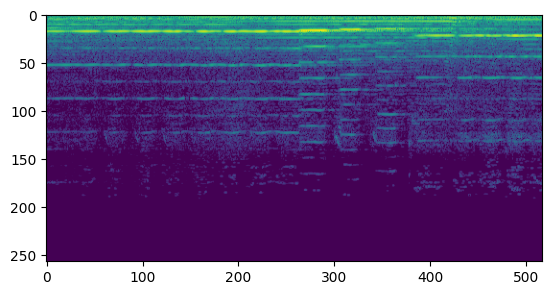

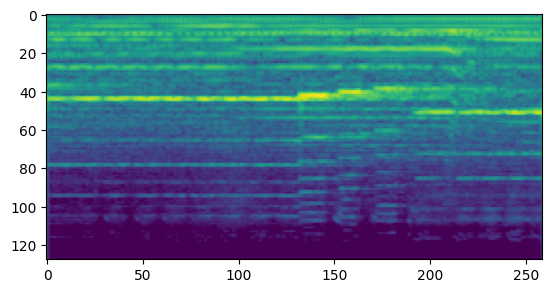

In [29]:
song_path = Path("./Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__1.wav")

spec = get_spec(center_clip(get_song(song_path)))
display(spec.shape)
plot.figure()
plot.imshow(spec)
spec = get_mag(center_clip(get_song(song_path)))
display(spec.shape)
plot.figure()
plot.imshow(spec)

## Metrike

Funkcija preciznosti kao što je opisana u uputama.

In [30]:
def AccuracyMulti(tresh=0.5):
    def acc(x, y):
        return 1 - (((x > tresh).float() - y).abs()).float().mean()
    return acc
AccuracyMulti()(torch.tensor([[0.1, 0.9, 0.4], [0.2, 0.2, 0.6]]), torch.tensor([[1, 1, 0], [0, 0, 1]]))

tensor(0.8333)

## Transformacije i augmentacije

In [31]:
# Transformacije koje se rade na svakoj pjesmi za dohvaćanje pjesme
get_song_tfms = [ToSong(), RandomClip(), CenterClip()]
# Transformacije koje se rade na svakoj pjesmi za dohvaćanje labele
# ne izvršava se ukoliko validiramo podatke
get_label_tfms = [get_label, MultiCategorize(vocab=['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']), OneHotEncode()]
# Transformacije za dohvaćanje samo prve labele (za monofoniju)
get_single_label_tfms = [get_single_label, Categorize()]

In [32]:
# Dobro za smanjivanje dataseta prilikom testiranja rada funkcija
def get_subset(x, p=0.9):
    return [x[i] for i in RandomSplitter(p)(x)[0]]

In [33]:
class AddRandomSongs(ItemTransform):
    split_idx = 0
    def __init__(self, items, augm=[], num=1, perc=0.5):
        self.items = np.array(items)
        self.get_song_pipe = Pipeline(get_song_tfms)
        self.augm_pipe = Pipeline(augm)
        self.get_label_pipe = Pipeline(get_label_tfms)
        self.num = num
        self.perc = perc
    
    def get_random_songs(self, k):
        files = np.random.choice(self.items, k)
        self.augm_pipe.split_idx = 0
        self.get_song_pipe.split_idx = 0
        X = [self.augm_pipe([self.get_song_pipe(f)])[0] for f in files]
        Y = [self.get_label_pipe(f) for f in files]
        return X, Y
        
    def encodes(self, item):
        if np.random.rand() >= self.perc: return item
        x, y = item
        l = np.random.poisson(self.num)
        X, Y = self.get_random_songs(l)
        X.append(x)
        Y.append(y)
        x = sum(X)
        y = TensorMultiCategory([min(i, 1) for i in sum(Y)])
        return [x, y]

In [34]:
class PitchShift(ItemTransform):
    split_idx = 0
    def __init__(self, perc=0.5, pitch=10):
        self.perc=perc
        self.pitch=pitch
        
    def encodes(self,item):
        if np.random.rand() >= self.perc: return item
        x = item[0]
        n_steps = np.random.rand()*self.pitch-self.pitch/2
        x = librosa.effects.pitch_shift(x,sr=sample_rate, n_steps=n_steps)
        return [x] + item[1:]

In [35]:
class GaussianNoise(ItemTransform):
    split_idx = 0
    def __init__(self, perc=0.5, noise=0.005):
        self.perc=perc
        self.noise=noise
        
    def encodes(self,item):
        if np.random.rand() >= self.perc: return item
        x = item[0]
        noise = np.random.randn(len(x))*self.noise - self.noise/2
        x = x + 0.005*noise
        return [x] + item[1:]

In [36]:
class RandomRotate(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(self.l*sample_rate)
        i = np.random.randint(-maxran, maxran+1)
        x = np.roll(x, i)
        return [x] + item[1:]

In [37]:
class RandomEdgeSilence(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(sample_rate*self.l)
        i = np.random.randint(-maxran, maxran+1)
        if i < 0: x[i:] = 0
        else: x[:i] = 0
        return [x] + item[1:]

In [38]:
class RandomAmp(ItemTransform):
    split_idx = 0
    def __init__(self, perc=0.5, rng=[0.6,2]):
        self.perc=perc
        self.rng = rng
    def encodes(self, item):
        if np.random.rand() >= self.perc: return item
        x = item[0]
        x = x * np.random.uniform(self.rng[0], self.rng[1])
        return [x] + item[1:]

In [39]:
class ToImg(ItemTransform):
    def encodes(self, item):
        return [PILImage.create(item[0])] + item[1:]

In [40]:
class ToSpec(ItemTransform):
    def __init__(self, tfm):
        self.tfm = tfm
    def encodes(self, item):
        return [self.tfm(item[0])] + item[1:]

In [41]:
# Dobro je za pokazati pjesmu kako izgleda nakon augmentacija
class ShowSong(ItemTransform):
    split_idx = 0
    def __init__(self, k=10):
        self.cnt = 0
        self.k = k
    def encodes(self, item):
        x, y = item
        if self.cnt < self.k + 1:
            if 0 < self.cnt:
                display(y)
                display(Audio(data=x, rate=sample_rate))
            self.cnt += 1
        return item

## Model

In [42]:
def get_dataset(items, splitter=RandomSplitter(), label_tfms=get_label_tfms):
    splits = splitter(items)
    return Datasets(items, [get_song_tfms, label_tfms], splits=splits)

In [43]:
def get_dataloader(ds, augm, tfms, resize=None):
    after_item = augm + tfms + [ToImg(), 
                                resize,
                                ToTensor(),
                                IntToFloatTensor()]
    return ds.dataloaders(bs=64, after_item=after_item, shuffle=True)

In [44]:
test_valid_splitter = FuncSplitter(lambda x: not is_IRMAS_train(x))
test_splitter = FuncSplitter(lambda x: is_IRMAS_test(x))

In [45]:
def get_learner(items, augm, tfms,
                arch=resnet18,
                pretrained=True,
                resize=None,
                splitter=test_splitter,
                label_tfms=get_label_tfms,
                metrics=AccuracyMulti(tresh=0.6)):
    ds = get_dataset(items, splitter=splitter, label_tfms=get_label_tfms)
    dls = get_dataloader(ds, augm, tfms, resize)
    learn = vision_learner(dls, arch, pretrained=pretrained, metrics=metrics)
    return learn

Po volji možemo mijenjati augm i tfms funkcije i vidjeti kakvi su rezultati nakon treniranja i validiranja.

In [ ]:
augm = [
    RandomRotate(l=1.5),
    RandomEdgeSilence(l=1.5),
    PitchShift(perc=0.3, pitch=3),
    GaussianNoise(perc=0.3, noise=0.007),
    RandomAmp(rng=[0.8,1.3], perc=0.6)
]
tfms = [
    AddRandomSongs(train_items + valid_items,
                   augm=augm, num=1.7, perc=0.4),
    ToSpec(get_spec),
]
learn = get_learner(items=train_items + valid_items + test_items,
                    augm=augm, tfms=tfms, arch=models.resnet18,
                    splitter=test_splitter,
                    resize=Resize((256, 156), method=ResizeMethod.Squish))

Učitavanje najboljeg modela.

In [ ]:
learn = learn.load("MLBLCLA2_model")

In [48]:
learn.validate()

(#2) [0.3000277578830719,0.8954830765724182]

In [118]:
# Obično treniranje u 4 epohe
# learn.fine_tune(8, 3.981071586167673e-06)

In [119]:
# learn.export("MLBLCLA3_206x206")

In [138]:
# learn.lr_find()

In [139]:
# learn.fine_tune(8, 0.0008317637839354575)

In [58]:
# learn.lr_find() traži optimalan learning rate, odkomentirati sljedeću liniju za trening s tim lr-u
# learn.fine_tune(8, 0.0002290867705596611)

In [59]:
# learn.lr_find()

In [63]:
print(len(learn.dls.train.items))
print(len(learn.dls.valid.items))

7341
2238


## Track GPU usage

Naredne funkcije će raditi samo ako imate Nvidia grafičku, instaliranu cudu te instaliran PyTorch s podrškom za cudu. Upute za takvu instalaciju su na githubu.

Funkcije koristimo za brisanje privremene memorije na grafičkoj kartici koju ona sama ne briše. Dobro je prilikom puno treniranja različitih modela. Između svakog novog modela potrebno je počistiti memoriju kako nebi došlo do overflowa i kršenja notebooka!

Ako ne koristite cudu, treniranje će biti značajno sporije ali bi trebalo raditi. Isto tako i za validaciju.

In [64]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [65]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [66]:
import gc
def report_gpu():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    gc.collect()
    torch.cuda.empty_cache()

In [67]:
report_gpu()

Memory Usage:
Allocated: 0.2 GB
Cached:    0.6 GB


## Test data

U narednim funkcijama implementiramo klizeće prozore za validaciju te automatiziramo procese za testiranje.

Prepoznavanje jedne datoteke

In [68]:
def get_sl_windows(song, step=sample_rate):
    ran = range(0, len(song)-sample_rate-step, step)
    if len(ran) == 0: yield extend_to_3sr([0])
    for i in ran: 
        yield extend_to_3sr(song[i:i+sample_rate*3])

In [69]:
def predict(learn, song, step=sample_rate, tresh=0.65, perc=0.20):
    instr = np.zeros(len(learn.dls.vocab))
    for n, sl in enumerate(get_sl_windows(song)):
        try:
            with io.capture_output() as captured:
                instr[learn.predict(sl)[1] > tresh] += 1
        except:
            instr[learn.predict(sl)[1] > tresh] += 1
    return learn.dls.vocab[instr > (n+1)*perc]

In [70]:
def get_accuracy(preds, tresh=0.5):
    fp, fn, _ = get_accuracy_per_instr(preds, tresh)
    fp, fn = sum(fp) / len(preds[0][0]), sum(fn) / len(preds[0][0])
    return fp, fn, fp + fn 

In [71]:
def get_accuracy_per_instr(preds, tresh=0.5):
    ms = np.array(np.logical_xor(preds[0] > tresh, preds[1]), np.int32)
    fp = np.array(np.logical_and(ms, np.logical_not(preds[1])), np.int32)
    fn = np.array(np.logical_and(ms, preds[1]), np.int32)
    n = len(preds[0])
    fp, fn = sum(fp) / n, sum(fn) /n
    return fp, fn, fp + fn

In [72]:
def print_validate(learn, tresh=0.5):
    fp, fn = validate(learn, tresh=tresh)
    print(tresh, sum(fp)/11, sum(fn)/11, sum(fp)/11 + sum(fn)/11, sep="\n")

Prepoznavanje više datoteka odjednom

Daleko je brže od testiranja jedne po jedne.

In [73]:
def get_preds_mult(learn, items, with_labels=True):
    my_items = []
    for i, item in enumerate(items):
        if isinstance(item, np.ndarray):
            l = int(len(item) / sample_rate)-1
            for win in range(l):
                my_items.append(PathNp(item, win*sample_rate))
        elif isinstance(item, Path):
            l = int(librosa.get_duration(path=item))-1
            for win in range(l): 
                my_items.append(PathPt(item, win*sample_rate))
        else: raise Exception("Invalid type!")
    test_dl = learn.dls.test_dl(my_items, with_labels=with_labels, rm_type_tfms=0)
    preds = learn.get_preds(dl=test_dl)
    return my_items, preds

In [74]:
def tresh_mult(items, preds,  with_labels=True, tresh=0.56, len_tresh=0.26):
    itempreds = dict()
    labs = dict()
    lens = dict()
    if type(tresh) == type(0.5): tresh = tensor([tresh for _ in preds[0][0]])
    else: tresh = tensor(tresh)
    pred = np.array(preds[0] > tresh, np.int32)

    idx = 0
    for i, item in enumerate(items):
        if isinstance(item, PathPt) and item.pat != items[idx].pat or isinstance(item, PathNp) and all(item.y != items[idx].y):
            idx = i
        if idx not in itempreds:
            itempreds[idx] = pred[i]
            if with_labels: labs[idx] = preds[1][i]
            lens[idx] = 1
        else:
            itempreds[idx] += pred[i]
            lens[idx] += 1

    final_preds = []
    final_labs = []
    for idx in itempreds:
        final_pred = itempreds[idx] > lens[idx] * len_tresh
        final_preds.append(final_pred)
        if with_labels: final_labs.append(np.array(labs[idx], np.int32))
    final_preds = tensor(final_preds, dtype=torch.float32)
    final_labs = tensor(final_labs, dtype=torch.float32) if with_labels else None
    return final_preds, final_labs

In [75]:
def predict_multi(learn, items, tresh=0.56, len_tresh=0.26):
    mitems, mpreds = get_preds_mult(learn, items, with_labels=False)
    return tresh_mult(mitems, mpreds, with_labels=False, tresh=tresh, len_tresh=len_tresh)
#     return [learn.dls.vocab[np.array(pred, bool)] for pred in mpreds[0]]

In [76]:
# preds = predict_multi(learn, test_items)

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/fastai/torch_core.py:150: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  else torch.tensor(x, **kwargs) if isinstance(x, (tuple,list,numbers.Number))


In [182]:
# [learn.dls.vocab[np.array(pred, dtype=bool)] for pred in preds[0]]

### Traženje najboljih tresholda

In [78]:
def get_best_tresh(mitems, mpreds):
    tab = []
    dicti = dict()
    for tresh_ind in range(1, 100, 5):
        tab.append([])
        for len_tresh_ind in range(1,100, 5):
            tresh = tresh_ind/100
            len_tresh = len_tresh_ind/100
            preds = tresh_mult(mitems, mpreds, tresh=tresh, len_tresh=len_tresh)
            ac = 1 - get_accuracy(preds)[2]
            tab[-1].append(ac)
            dicti[(tresh, len_tresh)] = ac
    tab = np.array(tab)
    tab[tab < 0.85] = 0.85
    plt.imshow(tab, extent=[0,1,1,0])
    plt.colorbar()
    plt.show()
    best_tresh = max(dicti, key=dicti.get)
    print("Best (tresh, len_tresh):", best_tresh)
    print("Accuracy:", dicti[best_tresh])
    return best_tresh

In [184]:
# mitems_test, mpreds_test = get_preds_mult(learn, test_items)

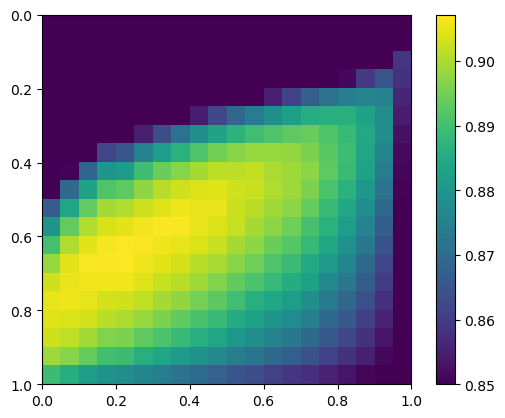

Best (tresh, len_tresh): (0.66, 0.21)
Accuracy: 0.9071817369404501


(0.66, 0.21)

In [185]:
# get_best_tresh(mitems_test, mpreds_test)

In [186]:
# mitems_valid, mpreds_valid = get_preds_mult(learn, train_items + valid_items)

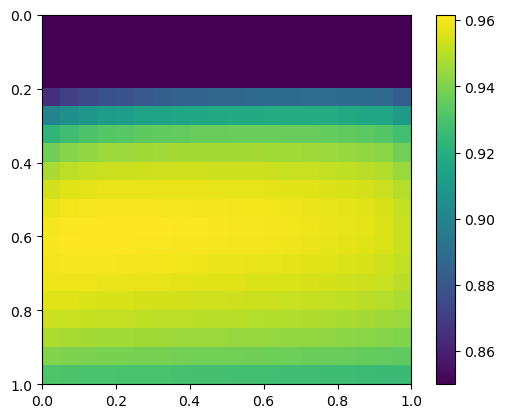

Best (tresh, len_tresh): (0.56, 0.11)
Accuracy: 0.9616599175242412
Accuracy on test set: 0.900438703387765


In [187]:
# tresh, len_tresh = get_best_tresh(mitems_valid, mpreds_valid)
# preds = tresh_mult(mitems_test, mpreds_test, tresh=tresh, len_tresh=len_tresh)
# print("Accuracy on test set:", 1 - get_accuracy(preds)[2])

In [188]:
# mitems_onlytrain, mpreds_onlytrain = get_preds_mult(learn, train_items)

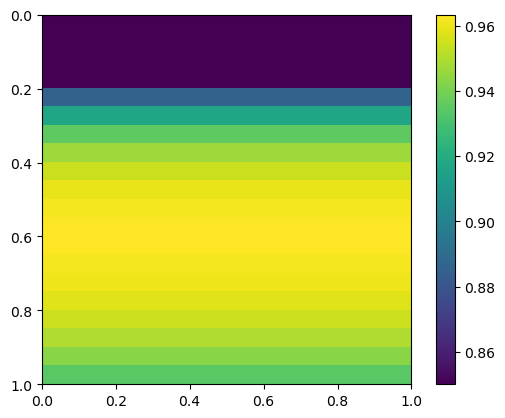

Best (tresh, len_tresh): (0.56, 0.01)
Accuracy: 0.9634194291912412
Accuracy on test set: 0.8796815338370298


In [189]:
# tresh, len_tresh = get_best_tresh(mitems_onlytrain, mpreds_onlytrain)
# preds = tresh_mult(mitems_test, mpreds_test, tresh=tresh, len_tresh=len_tresh)
# print("Accuracy on test set:", 1 - get_accuracy(preds)[2])

In [190]:
# mitems_onlyvalid, mpreds_onlyvalid = get_preds_mult(learn, valid_items)

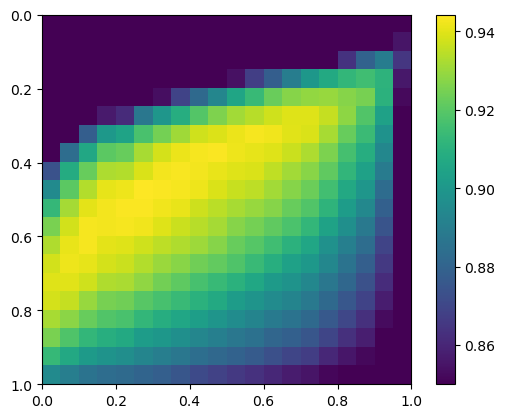

Best (tresh, len_tresh): (0.46, 0.26)
Accuracy: 0.9442538593481989
Accuracy on test set: 0.8977983589243643


In [191]:
# tresh, len_tresh = get_best_tresh(mitems_onlyvalid, mpreds_onlyvalid)
# preds = tresh_mult(mitems_test, mpreds_test, tresh=tresh, len_tresh=len_tresh)
# print("Accuracy on test set:", 1 - get_accuracy(preds)[2])

In [192]:
# preds = tresh_mult(mitems_test, mpreds_test, tresh=0.56, len_tresh=0.26)
# 1 - get_accuracy(preds)[2]

0.9062068405231944

In [79]:
def get_best_tresh_per_instr(mitems, mpreds, len_tresh=0.26):
    ac = 1 - get_accuracy(mpreds)[2]
    tresh = [0.5 for _ in mpreds[0][0]]
    for i in range(len(mpreds[0][0])):
        instr_tresh = dict()
        for tresh_ind in range(1, 100, 5):
            tresh[i] = tresh_ind / 100
            preds = tresh_mult(mitems, mpreds, tresh=tresh, len_tresh=len_tresh)
            ac = 1 - get_accuracy(preds)[2]
            instr_tresh[tresh[i]] = ac
        instr_tresh = max(instr_tresh, key=instr_tresh.get)
        tresh[i] = instr_tresh
    return tresh

## Get JSON predictions

In [80]:
def get_number(pat):
    return int(str(pat).split('.')[0].split('_')[-1])

def get_json(items, name="preds.json"):
    preds, _ = predict_multi(learn, items, tresh=0.56, len_tresh=0.26)
    x = dict()
    for i, pat in enumerate(items):
        x["track_"+str(get_number(pat))] = dict(zip(learn.dls.vocab, [int(j) for j in np.array(preds[i], dtype=int)]))
    with open(name, "w") as file:
        file.write(json.dumps(x))

In [81]:
real_test_items = get_song_files(grand_path/"test_dataset")
get_json(real_test_items, "preds_3.json")